In [23]:
import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F

from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt

In [2]:
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files

In [3]:
!pwd

/home/sergei/git/science/causality-disentanglement/debug


In [4]:
load_config_files(['../keychest/config/5x5.gin'])

['5x5']

In [5]:
env = EnvDataCollector(load_env())

Make environment KeyChest-v0 None {}


In [14]:
h, w, c = env.env.engine._observation.shape

In [20]:
from keychest.keychestenv import keychest_obs3d_to_obs2d, keychest_obs2d_to_image

In [18]:
# hwc
obs = env.reset()
obs = obs.reshape(h, w, c)

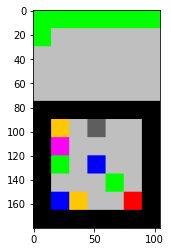

In [25]:
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs)))
plt.show()

In [6]:
for _ in tqdm(range(10000)):
    done = False
    np.random.seed(42)
    env.reset()
    while not done:
        _, _, _, done = env.step(env.action_space.sample())
env.flush()

KeyboardInterrupt: 

In [118]:
np.prod(env.engine._observation.shape)

924

In [112]:
np.sum([np.prod(x.shape) for x in env.engine.maps.values()])

275

In [113]:
obs.shape

(20000, 924)

In [95]:
data = env.raw_data

In [96]:
obs = np.array([x['observation'] for rollout in data for x in rollout])

In [76]:
set(obs.flatten())

{0.0, 1.0}

In [77]:
obs =  obs[:, np.std(obs, axis=0) > 0]

In [78]:
obs.shape

(20000, 6)

In [84]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca = PCA(n_components=2)
out = pca.fit_transform(normalize(obs))

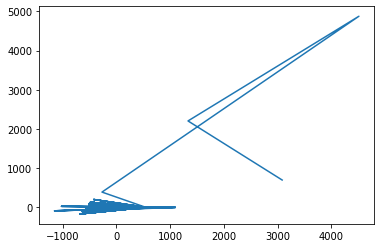

In [85]:
plt.plot(out[:, 0], out[:, 1])

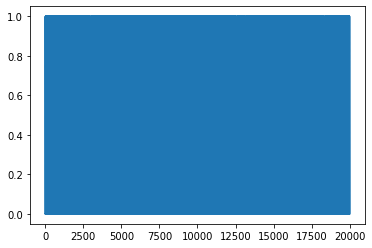

In [94]:
plt.plot(obs[:, 5])

In [ ]:
obs = env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [ ]:
env.reset()

In [8]:
env.observation_space

Box(0.0, 1.0, (924,), float32)

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0107, -0.0034, -0.0014,  0.0963,  0.1005,  0.0353,  0.0103,  0.1442,
          0.0725, -0.0114]], grad_fn=<AddmmBackward>)
